
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

#### Importação de bibliotecas

In [2]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import re

# Bibliotecas para preparação dos dados
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from unidecode import unidecode

# Bibliotecas para exibição de gráficos
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sbn

# Bibliotecas relacionadas à arquitetura da rede neural
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [557]:
GLOVE_EMBEDDINGS = {}

In [558]:
# Carregando os vetores GloVe
glove_file = '../embeddings/glove.6B.50d.txt'

In [559]:
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        
        # Tratando a substituição da vírgula por ponto no vetor de embedding
        if ',' in values[1]:
            embedding = [float(val.replace(',', '.')) for val in values[1:]]
        
        GLOVE_EMBEDDINGS[word] = embedding
print('Achados %s vetores de palavras' % len(GLOVE_EMBEDDINGS))

Achados 400000 vetores de palavras


In [560]:
# Carregando dataset pre-processado
df = pd.read_csv('../datasets/buscape_processed.csv')

In [561]:
# Balanceado dataset
from imblearn.over_sampling import RandomOverSampler

In [562]:
# Criando uma instância do RandomOverSampler
ros = RandomOverSampler()

In [563]:
# Alterarando o shape dos dados para uma representação com uma única coluna
# Os dados foram mantidos, mas agora X possui uma coluna adicional, tornando-se uma matriz bidimensional em vez de uma matriz unidimensional
X = np.array(df['review_text'])
X = X.reshape(-1, 1)

In [564]:
y = df['rating']

In [565]:
# Aplicando o RandomOverSampler para gerar novas amostras
X_res, y_res = ros.fit_resample(X, y)

In [566]:
# Verificando dataset após balanceamento
print(pd.Series(y_res).value_counts())

rating
1    66816
0    66816
Name: count, dtype: int64


In [567]:
# definindo corpus
CORPUS = df['review_text']

In [568]:
CORPUS = [str(text) for text in CORPUS]

In [636]:
MAX_WORDS = 16000

In [637]:
tokenizer = Tokenizer(num_words=MAX_WORDS)

In [638]:
tokenizer.fit_on_texts(CORPUS)

In [639]:
WORD_INDEX = tokenizer.word_index

In [640]:
print(f'Quantindade de palavras: {MAX_WORDS}')

Quantindade de palavras: 16000


In [641]:
SEQUENCES = tokenizer.texts_to_sequences(CORPUS)

In [642]:
X = pad_sequences(SEQUENCES, truncating='post', padding='post')

In [643]:
INPUT_LENGTH = len(X[0])

In [644]:
print(f'Dimensão de embeddings dos vetores do corpus: {INPUT_LENGTH}')

Dimensão de embeddings dos vetores do corpus: 808


In [645]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [646]:
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (58900, 808)
y_train: (58900,)
X_test: (14726, 808)
y_test: (14726,)


In [647]:
# Dimensão do embedding do glove
EMBED_DIM = 50

In [648]:
EMBEDDING_MATRIX = np.zeros((MAX_WORDS, EMBED_DIM))
print(EMBEDDING_MATRIX.shape)

(16000, 50)


In [649]:
# Montando matriz de pesos do glove
for word, index in WORD_INDEX.items():
    if index > MAX_WORDS-1:
        continue
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDING_MATRIX[index] = embedding_vector

In [650]:
EMBEDDING_MATRIX.shape

(16000, 50)

In [651]:
model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS,output_dim=EMBED_DIM, input_length=INPUT_LENGTH, weights=[EMBEDDING_MATRIX]))
model.add(Flatten())
model.add(Dense(24, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))

In [652]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 808, 50)           800000    
                                                                 
 flatten_11 (Flatten)        (None, 40400)             0         
                                                                 
 dense_26 (Dense)            (None, 24)                969624    
                                                                 
 dropout_6 (Dropout)         (None, 24)                0         
                                                                 
 dense_27 (Dense)            (None, 1)                 25        
                                                                 
Total params: 1,769,649
Trainable params: 1,769,649
Non-trainable params: 0
_________________________________________________________________


In [653]:
LEARNING_RATE = 5e-4
LOSS = 'binary_crossentropy'
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['acc']
BATCH_SIZE = 32
EPOCHS = 10
CALLBACKS = [tf.keras.callbacks.EarlyStopping('val_loss', patience=3)]

In [654]:
# Compilando o modelo
model.compile(
    loss=LOSS,
    optimizer=OPTIMIZER, 
    metrics=METRICS
)

In [655]:
model_history = model.fit(
    X_train, 
    y_train, 
    verbose=1, 
    batch_size=BATCH_SIZE,  
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=CALLBACKS
)

Epoch 1/10
1841/1841 [==============================] - 65s 35ms/step - loss: 0.2460 - acc: 0.9113 - val_loss: 0.2014 - val_acc: 0.9264
Epoch 2/10
1841/1841 [==============================] - 70s 38ms/step - loss: 0.1767 - acc: 0.9408 - val_loss: 0.1864 - val_acc: 0.9364
Epoch 3/10
1841/1841 [==============================] - 66s 36ms/step - loss: 0.1363 - acc: 0.9559 - val_loss: 0.1810 - val_acc: 0.9430
Epoch 4/10
1841/1841 [==============================] - 72s 39ms/step - loss: 0.1103 - acc: 0.9658 - val_loss: 0.1960 - val_acc: 0.9436
Epoch 5/10
1841/1841 [==============================] - 73s 40ms/step - loss: 0.0904 - acc: 0.9716 - val_loss: 0.2217 - val_acc: 0.9428
Epoch 6/10
1841/1841 [==============================] - 88s 48ms/step - loss: 0.0736 - acc: 0.9775 - val_loss: 0.2555 - val_acc: 0.9420


In [656]:
NB_START_EPOCHS = 6

In [657]:
def eval_metric(history, metric_name):
    '''
    Função para avaliar o modelo treinado na métrica escolhida. 
    Treino e valição são plotados por época.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

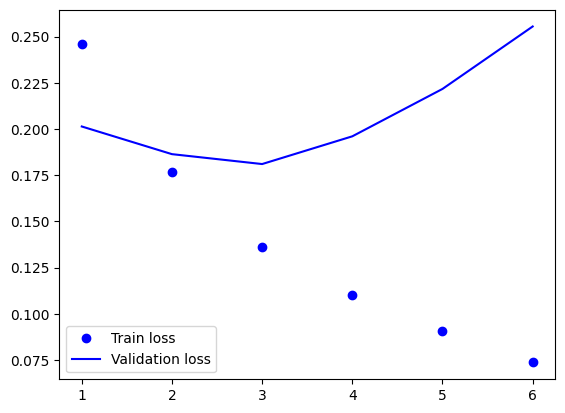

In [659]:
eval_metric(model_history, 'loss')

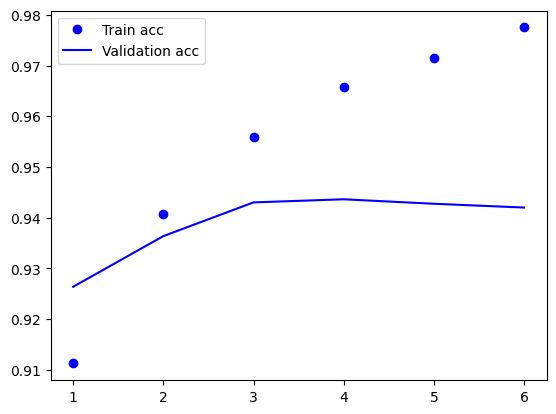

In [661]:
eval_metric(model_history, 'acc')

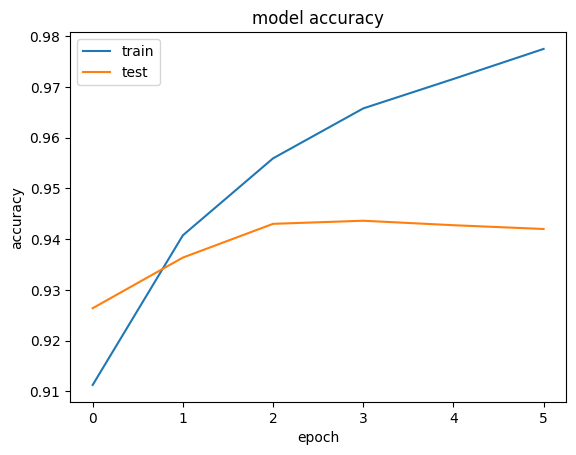

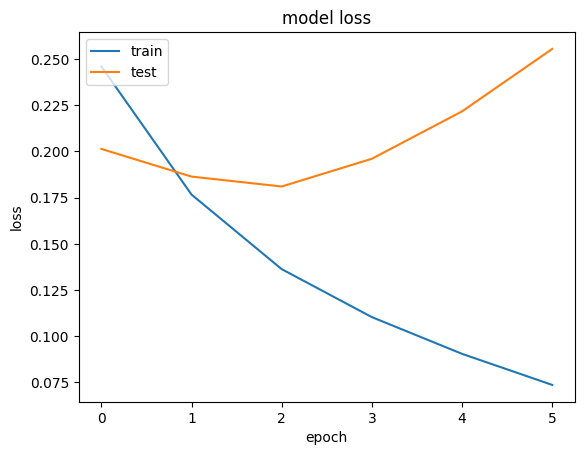

In [662]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [664]:
predicao = np.round(model.predict(X_test))

461/461 [==============================] - 2s 3ms/step


In [665]:
acc = accuracy_score(y_test, predicao)

In [666]:
acc

0.942007333967133

In [667]:
print(classification_report(y_test, predicao))

              precision    recall  f1-score   support

           0       0.78      0.51      0.62      1343
           1       0.95      0.99      0.97     13383

    accuracy                           0.94     14726
   macro avg       0.86      0.75      0.79     14726
weighted avg       0.94      0.94      0.94     14726



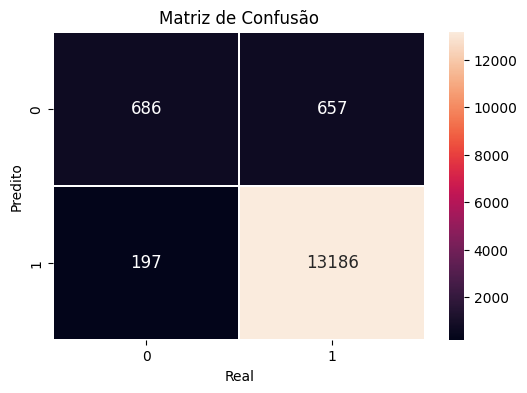

In [668]:
mc = confusion_matrix(y_test, predicao)
plt.figure(figsize=(6,4))
sbn.heatmap(mc, annot=True, linewidth=0.2, annot_kws={'size':12}, fmt='.0f')
plt.title("Matriz de Confusão", fontsize=12)
plt.xlabel('Real')
plt.ylabel('Predito')
plt.show()